🔁 Etapas deste primeiro pipeline:
Importar os dados (train.csv)

Pré-processamento simples de texto:

Lowercasing

Remoção de pontuação

Remoção de stopwords

Tokenização

Transformação do texto em vetores numéricos (Bag of Words)

Treino de um modelo simples de classificação (por exemplo, LogisticRegression ou MultinomialNB)

Avaliação do modelo com Accuracy, Precision, Recall e F1-Score

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports

In [2]:
# Bibliotecas principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualização de textos
from wordcloud import WordCloud

# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")


### Loading Data

In [3]:
# Caminho para a pasta no teu Drive
base_path = "/content/drive/MyDrive/Text Mining/Project"

# Carregar os datasets
train_df = pd.read_csv(f"{base_path}/train.csv")
test_df = pd.read_csv(f"{base_path}/test.csv")

# Verificar as 5 primeiras linhas
train_df.head()


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


### EDA

#### Initial Inspection

In [4]:
print("Shape:", train_df.shape)

Shape: (9543, 2)


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


In [11]:
train_df.describe()

,label
count,9543.000000
mean,1.496280
std,0.743139
min,0.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,2.000000


Missing Values

In [12]:
train_df.isnull().sum()

,0
text,0
label,0


Class Distribution

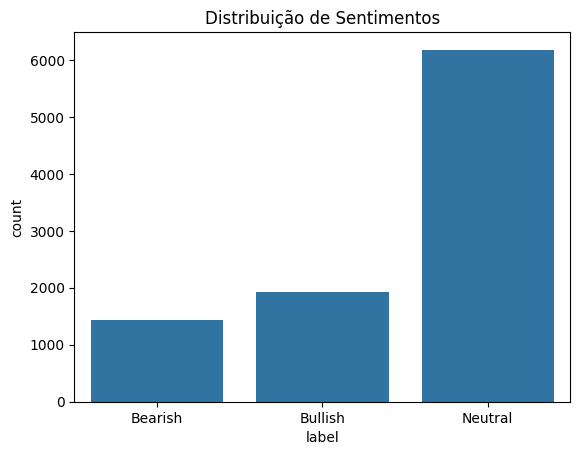

In [13]:
sns.countplot(data=train_df, x='label')
plt.title("Distribuição de Sentimentos")
plt.xticks([0, 1, 2], ['Bearish', 'Bullish', 'Neutral'])
plt.show()

#### Text Analysis

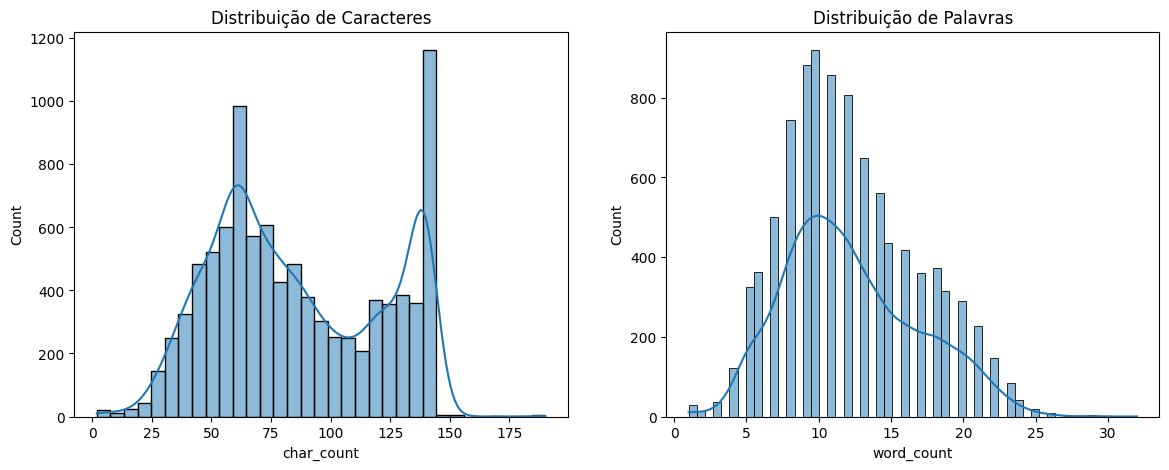

In [14]:
# Comprimento em caracteres e palavras
train_df['char_count'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

# Histograma dos comprimentos
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(train_df['char_count'], kde=True, ax=axs[0]).set_title("Distribuição de Caracteres")
sns.histplot(train_df['word_count'], kde=True, ax=axs[1]).set_title("Distribuição de Palavras")
plt.show()


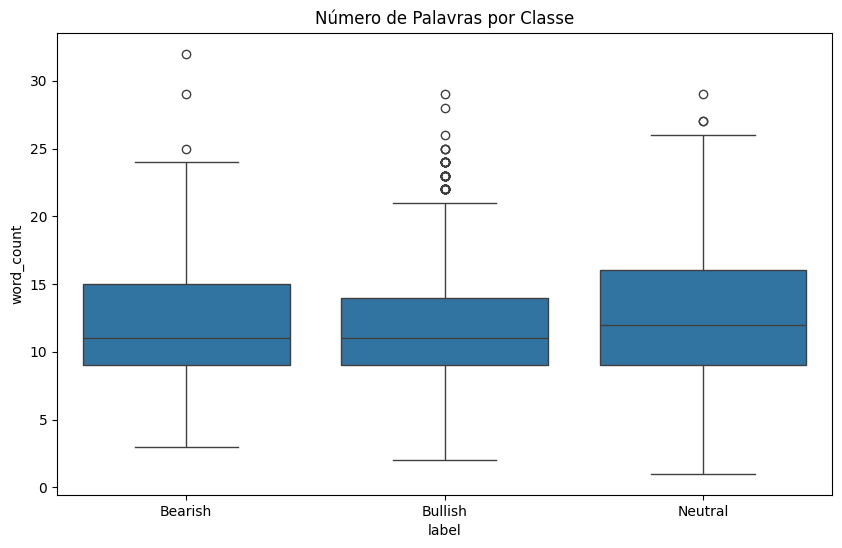

In [15]:
# Comprimento por classe
plt.figure(figsize=(10,6))
sns.boxplot(x='label', y='word_count', data=train_df)
plt.title("Número de Palavras por Classe")
plt.xticks([0, 1, 2], ['Bearish', 'Bullish', 'Neutral'])
plt.show()

#### Wordclouds

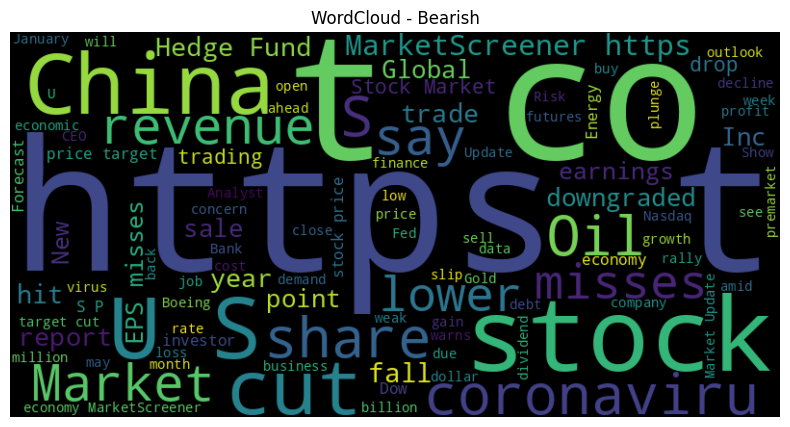

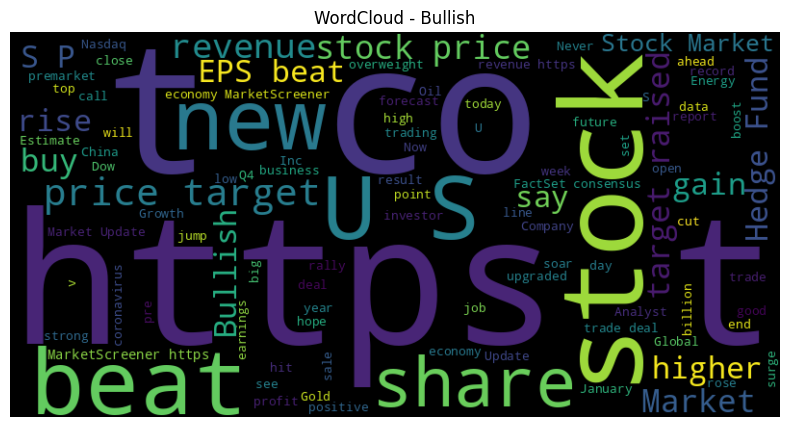

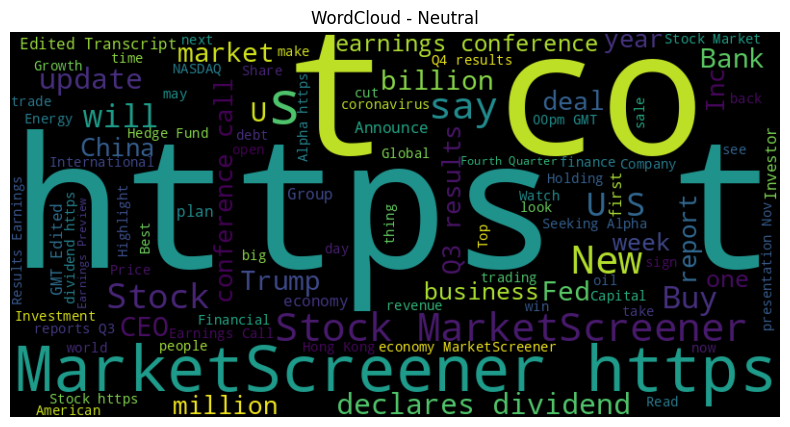

In [16]:
from wordcloud import WordCloud

# Função para wordcloud por classe
def show_wordcloud(data, label_name):
    text = " ".join(data)
    wordcloud = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud - {label_name}")
    plt.show()

for label, name in zip([0,1,2], ['Bearish', 'Bullish', 'Neutral']):
    show_wordcloud(train_df[train_df['label'] == label]['text'], name)


#### Noisy Data

In [17]:
import re

# Funções auxiliares
train_df['has_url'] = train_df['text'].apply(lambda x: int(bool(re.search(r"http\S+|www\S+", x))))
train_df['has_hashtag'] = train_df['text'].apply(lambda x: int(bool(re.search(r"#\w+", x))))
train_df['has_mention'] = train_df['text'].apply(lambda x: int(bool(re.search(r"@\w+", x))))
train_df['has_emoji'] = train_df['text'].apply(lambda x: int(bool(re.search(r"[^\w\s,]", x))))

# Percentagens
for col in ['has_url', 'has_hashtag', 'has_mention', 'has_emoji']:
    print(f"{col}: {train_df[col].mean():.2%}")

# Duplicados
print(f"\nTextos duplicados: {train_df.duplicated('text').sum()} ({train_df.duplicated('text').mean():.2%})")


has_url: 46.84%
has_hashtag: 9.39%
has_mention: 3.08%
has_emoji: 85.35%

Textos duplicados: 0 (0.00%)


#### Correlations and Key Words

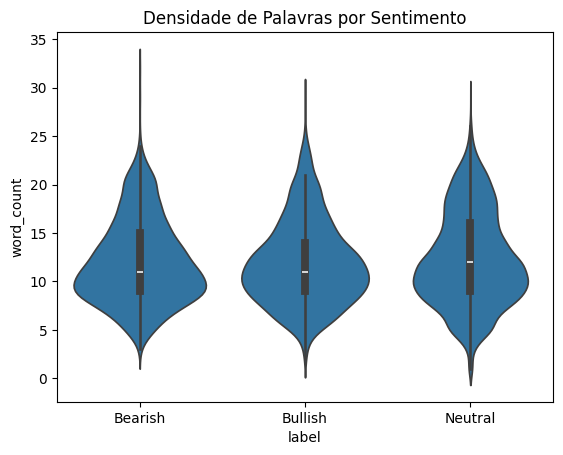


Top words - Bearish


,word,count
0,t,776
1,co,737
2,https,735
3,to,383
4,s,368
5,the,321
6,in,267
7,of,233
8,on,224
9,a,179



Top words - Bullish


,word,count
0,t,873
1,co,852
2,https,842
3,to,492
4,s,435
5,on,387
6,the,349
7,in,324
8,up,269
9,stock,258



Top words - Neutral


,word,count
0,t,3688
1,co,3559
2,https,3518
3,the,1892
4,to,1787
5,s,1441
6,of,1255
7,in,1058
8,a,995
9,for,882


In [18]:
# Correlação entre número de palavras e rótulo
sns.violinplot(x='label', y='word_count', data=train_df)
plt.title("Densidade de Palavras por Sentimento")
plt.xticks([0, 1, 2], ['Bearish', 'Bullish', 'Neutral'])
plt.show()

# Palavras mais comuns por classe
from collections import Counter

def top_words_per_class(df, label):
    text = " ".join(df[df['label'] == label]['text'])
    words = re.findall(r'\b\w+\b', text.lower())
    common = Counter(words).most_common(15)
    return pd.DataFrame(common, columns=['word', 'count'])

for label, name in zip([0,1,2], ['Bearish', 'Bullish', 'Neutral']):
    print(f"\nTop words - {name}")
    display(top_words_per_class(train_df, label))


### Pre-Process

In [26]:
# pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 23.6 MB/s eta 0:00:00


In [27]:
import emoji
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict

nltk.download('stopwords')
nltk.download('wordnet')

tokenizer = TweetTokenizer(preserve_case=False)
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:
def preprocess_advanced(text):
    original_text = text

    # Sinais auxiliares
    has_url = int(bool(re.search(r"http\S+|www\S+", text)))
    has_hashtag = int(bool(re.search(r"#\w+", text)))
    has_emoji = int(bool(emoji.emoji_count(text) > 0))
    has_cashtag = int(bool(re.search(r"\$\w+", text)))

    # Substituir emojis por "emoji_positive", "emoji_negative" ou "emoji"
    def replace_emojis(text):
        for char in text:
            if emoji.is_emoji(char):
                sentiment = emoji.demojize(char)
                if any(k in sentiment for k in ['smile', 'grin', 'heart', 'sun']):
                    text = text.replace(char, "emoji_positive")
                elif any(k in sentiment for k in ['cry', 'angry', 'sad', 'frown']):
                    text = text.replace(char, "emoji_negative")
                else:
                    text = text.replace(char, "emoji")
        return text

    text = replace_emojis(text)

    # Extrair e expandir hashtags
    text = re.sub(r"#(\w+)", r"\1", text)

    # Expandir cashtags (marca que existe)
    text = re.sub(r"\$(\w+)", r"\1", text)

    # Remover URLs e menções
    text = re.sub(r"http\S+|www\S+|@\w+", "", text)

    # Detetar negações: not + palavra → not_palavra
    text = re.sub(r"\b(not|no|never|n't)\s+(\w+)", r"\1_\2", text)

    # Tokenização
    tokens = tokenizer.tokenize(text)

    # Limpeza e lematização
    clean_tokens = [
        lemmatizer.lemmatize(tok)
        for tok in tokens
        if tok not in stop_words and len(tok) > 1 and tok.isalpha()
    ]

    return {
        'clean_text': " ".join(clean_tokens),
        'has_url': has_url,
        'has_hashtag': has_hashtag,
        'has_emoji': has_emoji,
        'has_cashtag': has_cashtag,
    }


In [31]:
df = train_df.copy()
df.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [32]:
# Aplica a função de pré-processamento e divide em colunas
processed = df['text'].apply(preprocess_advanced).apply(pd.Series)

# Junta as novas colunas ao dataframe
df = pd.concat([df, processed], axis=1)

# Verifica o resultado
df[['text', 'clean_text', 'has_url', 'has_hashtag', 'has_emoji', 'has_cashtag']].head()


,text,clean_text,has_url,has_hashtag,has_emoji,has_cashtag
0,$BYND - JPMorgan reels in expectations on Beyo...,bynd jpmorgan reel expectation beyond meat,1,0,0,1
1,$CCL $RCL - Nomura points to bookings weakness...,ccl rcl nomura point booking weakness carnival...,1,0,0,1
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",cx cemex cut credit suisse morgan weak buildin...,1,0,0,1
3,$ESS: BTIG Research cuts to Neutral https://t....,es btig research cut neutral,1,0,0,1
4,$FNKO - Funko slides after Piper Jaffray PT cu...,fnko funko slide piper jaffray pt cut,1,0,0,1


In [36]:
# Mostrar o primeiro texto original completo
print("Texto original:\n", df.loc[0, 'text'])

# Mostrar a versão limpa
print("\nTexto pós-processado:\n", df.loc[0, 'clean_text'])

Texto original:
 $BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT

Texto pós-processado:
 bynd jpmorgan reel expectation beyond meat


#### Fast verification of the clean text

Média de palavras por tweet: 7.73215969820811


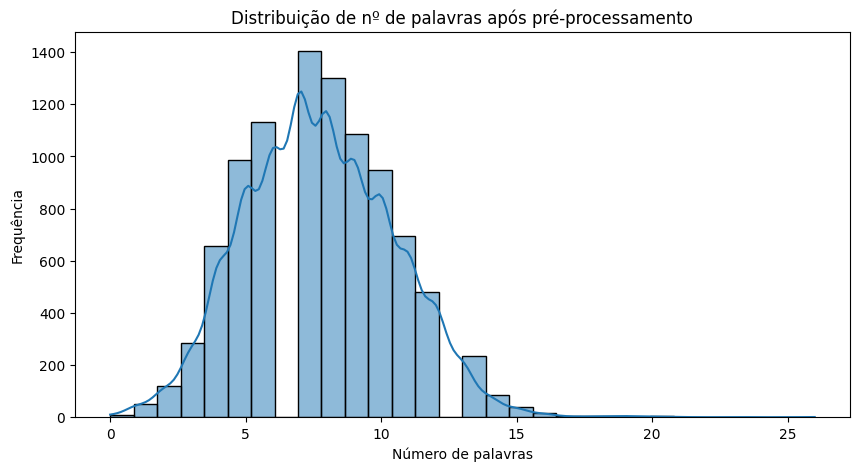

In [37]:
# Estatísticas de comprimento
df['word_count_clean'] = df['clean_text'].apply(lambda x: len(x.split()))
print("Média de palavras por tweet:", df['word_count_clean'].mean())

# Ver distribuições
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df['word_count_clean'], bins=30, kde=True)
plt.title("Distribuição de nº de palavras após pré-processamento")
plt.xlabel("Número de palavras")
plt.ylabel("Frequência")
plt.show()


In [38]:
from collections import Counter

all_words = " ".join(df['clean_text']).split()
common = Counter(all_words).most_common(20)
print("Top 20 palavras mais comuns:")
for word, count in common:
    print(f"{word}: {count}")


Top 20 palavras mais comuns:
stock: 1323
market: 536
marketscreener: 479
new: 416
report: 403
say: 390
price: 387
result: 381
earnings: 351
share: 342
economy: 330
inc: 316
update: 300
fund: 293
year: 276
dividend: 275
china: 272
buy: 265
deal: 257
trade: 251


### Feature Creation - no transformers

In [39]:
from sklearn.model_selection import train_test_split

# Features e target
X_text = df['clean_text']
X_aux = df[['has_url', 'has_emoji', 'has_hashtag', 'has_cashtag']]
y = df['label']

# Split (com stratify para manter proporções de classes)
X_text_train, X_text_val, X_aux_train, X_aux_val, y_train, y_val = train_test_split(
    X_text, X_aux, y, test_size=0.2, random_state=42, stratify=y
)



In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vetorizador
vectorizer = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1,2),
    min_df=2,
    sublinear_tf=True
)

# Fit no treino, transforma ambos
X_tfidf_train = vectorizer.fit_transform(X_text_train)
X_tfidf_val = vectorizer.transform(X_text_val)


In [41]:
from scipy.sparse import hstack

# Transformar os auxiliares para sparse
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
X_aux_train_scaled = scaler.fit_transform(X_aux_train)
X_aux_val_scaled = scaler.transform(X_aux_val)

# Concatenar TF-IDF + aux
X_train_final = hstack([X_tfidf_train, X_aux_train_scaled])
X_val_final = hstack([X_tfidf_val, X_aux_val_scaled])


In [42]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    class_weight='balanced',
    C=1.0,              # regularização — podemos ajustar
    solver='liblinear', # bom para sparse
    max_iter=1000
)
model.fit(X_train_final, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

In [43]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_val_final)
print(classification_report(y_val, y_pred, target_names=['Bearish', 'Bullish', 'Neutral']))


              precision    recall  f1-score   support

     Bearish       0.68      0.45      0.54       288
     Bullish       0.72      0.64      0.68       385
     Neutral       0.83      0.93      0.88      1236

    accuracy                           0.80      1909
   macro avg       0.75      0.67      0.70      1909
weighted avg       0.79      0.80      0.79      1909



### Bert Preparation

In [9]:
pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 19.4 MB/s eta 0:00:00


In [10]:
import emoji
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict

In [34]:
df = train_df.copy()
df.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [35]:
def prepare_for_bert(text):
    # Substituir URLs por token [URL]
    text = re.sub(r"http\S+|www\S+", "[URL]", text)
    # Remover espaços duplicados
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['bert_text'] = df['text'].apply(prepare_for_bert)

# Verificar exemplo
print("Original:", df.loc[0, 'text'])
print("Para BERT:", df.loc[0, 'bert_text'])


Original: $BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT
Para BERT: $BYND - JPMorgan reels in expectations on Beyond Meat [URL]


In [36]:
import re
import emoji

def detect_signals(text):
    return {
        'has_url': int(bool(re.search(r"http\S+|www\S+", text))),
        'has_hashtag': int(bool(re.search(r"#\w+", text))),
        'has_mention': int(bool(re.search(r"@\w+", text))),
        'has_cashtag': int(bool(re.search(r"\$\w+", text))),
        'has_emoji': int(emoji.emoji_count(text) > 0)
    }

signal_cols = df['text'].apply(detect_signals).apply(pd.Series)
df = pd.concat([df, signal_cols], axis=1)



In [37]:
df.columns

Index(['text', 'label', 'bert_text', 'has_url', 'has_hashtag', 'has_mention',
       'has_cashtag', 'has_emoji'],
      dtype='object')

In [38]:
def enrich_text(row):
    text = row['bert_text']
    tags = []
    if row['has_emoji']:
        tags.append("EMOJI_PRESENT")
    if row['has_url']:
        tags.append("URL_PRESENT")
    if row['has_cashtag']:
        tags.append("CASHTAG_PRESENT")
    if row['has_hashtag']:
        tags.append("HASHTAG_PRESENT")
    return " ".join(tags) + ": " + text if tags else text

df['bert_text_enriched'] = df.apply(enrich_text, axis=1)


In [45]:
# !pip install transformers datasets --quiet


In [39]:
# pip install datasets

In [14]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer
import pandas as pd


In [40]:
# Dividir com estratificação
df_train, df_val = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

# Confirmar equilíbrio
df_train['label'].value_counts(normalize=True), df_val['label'].value_counts(normalize=True)


(label
 2    0.647367
 1    0.201467
 0    0.151166
 Name: proportion, dtype: float64,
 label
 2    0.647459
 1    0.201676
 0    0.150864
 Name: proportion, dtype: float64)

In [41]:
train_data = Dataset.from_pandas(df_train[['bert_text_enriched', 'label']].rename(columns={'bert_text_enriched': 'text'}))
val_data = Dataset.from_pandas(df_val[['bert_text_enriched', 'label']].rename(columns={'bert_text_enriched': 'text'}))



In [43]:
train_data

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 7634
})

In [75]:
model_checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


In [76]:
# model_checkpoint = "microsoft/deberta-v3-small"
# tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [77]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=64  # tweets são curtos
    )

train_tokenized = train_data.map(tokenize_function, batched=True)
val_tokenized = val_data.map(tokenize_function, batched=True)

train_tokenized.set_format("torch")
val_tokenized.set_format("torch")


Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

In [78]:
from transformers import AutoModelForSequenceClassification

# 3 classes → Bearish (0), Bullish (1), Neutral (2)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
# pip install evaluate

In [80]:
import evaluate
import numpy as np

metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="macro")


In [86]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="./results_roberta",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_dir="./logs_roberta",
    logging_steps=50,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [87]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.112000,0.575800,0.859110
2,0.109400,0.526754,0.860987
3,0.049800,0.685338,0.854025
4,0.064800,0.645777,0.861656
5,0.046400,0.635277,0.879400
6,0.041000,0.673513,0.865404
7,0.021400,0.680965,0.881808
8,0.012300,0.754412,0.870217
9,0.008700,0.748398,0.872114


TrainOutput(global_step=2151, training_loss=0.0437389690406133, metrics={'train_runtime': 948.4602, 'train_samples_per_second': 80.488, 'train_steps_per_second': 2.52, 'total_flos': 2259683809802496.0, 'train_loss': 0.0437389690406133, 'epoch': 9.0})

In [88]:
val_predictions = trainer.predict(val_tokenized)
val_preds = np.argmax(val_predictions.predictions, axis=-1)

from sklearn.metrics import classification_report
print(classification_report(val_predictions.label_ids, val_preds, target_names=['Bearish', 'Bullish', 'Neutral']))


              precision    recall  f1-score   support

     Bearish       0.84      0.84      0.84       288
     Bullish       0.89      0.85      0.87       385
     Neutral       0.93      0.94      0.94      1236

    accuracy                           0.91      1909
   macro avg       0.89      0.88      0.88      1909
weighted avg       0.91      0.91      0.91      1909

